<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLMatchupCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install the library for NFL Data
!pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.0 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=abd0d6c983d071800ecbfa18efcf4c93c5a7a849df1d39d2930e4da0905e0164
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [3]:
# NFL Data Import
import nfl_data_py as nfl

# Imports
from math import pi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from math import pi
import urllib

In [4]:
stats = nfl.import_pbp_data([2023])

# Copy data
new_stats = stats.copy()

# Create Defensive EPA
new_stats['def_epa'] = -stats['epa']

stats = new_stats

# Filter Garbage Time
stats = stats[(stats["wp"] > .25) & (stats["wp"] < .975)]

2023 done.
Downcasting floats.


In [5]:
#REDZONE
redzone = stats[stats["drive_inside20"] == 1.0]
redzone_td = redzone[redzone["touchdown"] == 1.0]

redzone_drives = redzone.groupby("posteam")["drive_real_start_time"].nunique().reset_index()
redzone_tds = redzone_td.groupby("posteam")["touchdown"].size().reset_index()

redzone_tds["redzone_eff"] = redzone_tds["touchdown"] / redzone_drives["drive_real_start_time"] * 100

redzone_tds["redzone_eff_rank"] = redzone_tds["redzone_eff"].rank(method="max", ascending=True).astype(int)
redzone_tds = redzone_tds.sort_values("redzone_eff_rank", ascending=False).reset_index(drop = True)

redzone_tds = redzone_tds.rename(columns={"posteam": "team"})

In [6]:
passing = stats[stats["play_type"] == "pass"]
rushing = stats[stats["play_type"] == "run"]

# OFFENSE
passing_total = passing.groupby("posteam").size().reset_index(name = "pass_plays")
off_passing = passing.groupby("posteam")["epa"].sum().reset_index()

off_passing["off_passing_epa"] = off_passing["epa"] / passing_total["pass_plays"]

rushing_total = rushing.groupby("posteam").size().reset_index(name = "run_plays")
off_rushing = rushing.groupby("posteam")["epa"].sum().reset_index()

off_rushing["off_rush_epa"] = off_rushing["epa"] / rushing_total["run_plays"]


off_passing["off_passing_rank"] = off_passing["off_passing_epa"].rank(method="max", ascending=True).astype(int)
off_passing = off_passing.sort_values("off_passing_rank", ascending=False).reset_index(drop = True)

off_rushing["off_rushing_rank"] = off_rushing["off_rush_epa"].rank(method="max", ascending=True).astype(int)
off_rushing = off_rushing.sort_values("off_rushing_rank", ascending=False).reset_index(drop = True)

off_passing = off_passing.rename(columns={"posteam": "team"})
off_rushing = off_rushing.rename(columns={"posteam": "team"})

In [7]:
# DEFENSE
passing_total = passing.groupby("defteam").size().reset_index(name = "pass_plays")
def_passing = passing.groupby("defteam")["def_epa"].sum().reset_index()

def_passing["def_passing_epa"] = def_passing["def_epa"] / passing_total["pass_plays"]

rushing_total = rushing.groupby("defteam").size().reset_index(name = "run_plays")
def_rushing = rushing.groupby("defteam")["def_epa"].sum().reset_index()

def_rushing["def_rush_epa"] = def_rushing["def_epa"] / rushing_total["run_plays"]

def_passing["def_passing_rank"] = def_passing["def_passing_epa"].rank(method="max", ascending=True).astype(int)
def_passing = def_passing.sort_values("def_passing_rank", ascending=False).reset_index(drop = True)

def_rushing["def_rushing_rank"] = def_rushing["def_rush_epa"].rank(method="max", ascending=True).astype(int)
def_rushing = def_rushing.sort_values("def_rushing_rank", ascending=False).reset_index(drop = True)

def_passing = def_passing.rename(columns={"defteam": "team"})
def_rushing = def_rushing.rename(columns={"defteam": "team"})

In [8]:
# SUCCESS (Not Used)
passing = stats[stats["play_type"] == "pass"]
rushing = stats[stats["play_type"] == "run"]

passing_total = passing.groupby("posteam").size().reset_index(name = "pass_plays")
pass_success = passing.groupby("posteam")["success"].sum().reset_index()

pass_success["pass_success_percent"] = pass_success["success"] / passing_total["pass_plays"] * 100

rushing_total = rushing.groupby("posteam").size().reset_index(name = "run_plays")
rushing_success = rushing.groupby("posteam")["success"].sum().reset_index()

rushing_success["rush_success_percent"] = rushing_success["success"] / rushing_total["run_plays"] * 100

pass_success["pass_success_rank"] = pass_success["pass_success_percent"].rank(method="max", ascending=True).astype(int)
pass_success = pass_success.sort_values("pass_success_rank", ascending=False).reset_index(drop = True)

rushing_success["rush_success_rank"] = rushing_success["rush_success_percent"].rank(method="max", ascending=True).astype(int)
rushing_success = rushing_success.sort_values("rush_success_rank", ascending=False).reset_index(drop = True)

pass_success = pass_success.rename(columns={"posteam": "team"})
rushing_success = rushing_success.rename(columns={"posteam": "team"})

In [9]:
#TURNOVERS (Not used)
off_fumble = stats.groupby("posteam")["fumble_lost"].sum().reset_index()
off_int = stats.groupby("posteam")["interception"].sum().reset_index()

def_fumble = stats.groupby("defteam")["fumble_lost"].sum().reset_index()
def_int = stats.groupby("defteam")["interception"].sum().reset_index()

turnovers = pd.DataFrame(off_fumble["posteam"])
turnovers["turnover_diff"] = (def_fumble["fumble_lost"] + def_int["interception"]) - (off_fumble["fumble_lost"] + off_int["interception"])

turnovers["turnover_rank"] = turnovers["turnover_diff"].rank(method="max", ascending=True).astype(int)
turnovers = turnovers.sort_values("turnover_rank", ascending=False).reset_index(drop = True)

turnovers = turnovers.rename(columns={"posteam": "team"})

In [10]:
# Merge rank dataframes
column1 = off_passing
data_frames = [off_rushing, def_passing, def_rushing, turnovers, redzone_tds]

for columns in data_frames:
    column1 = pd.merge(column1, columns, on='team', how='left')

fin_ranks = column1[["team", "off_passing_rank","off_rushing_rank", "def_passing_rank", "def_rushing_rank", "redzone_eff_rank"]]

First Team Abbreviation: cin
Second Team Abbreviation: kc


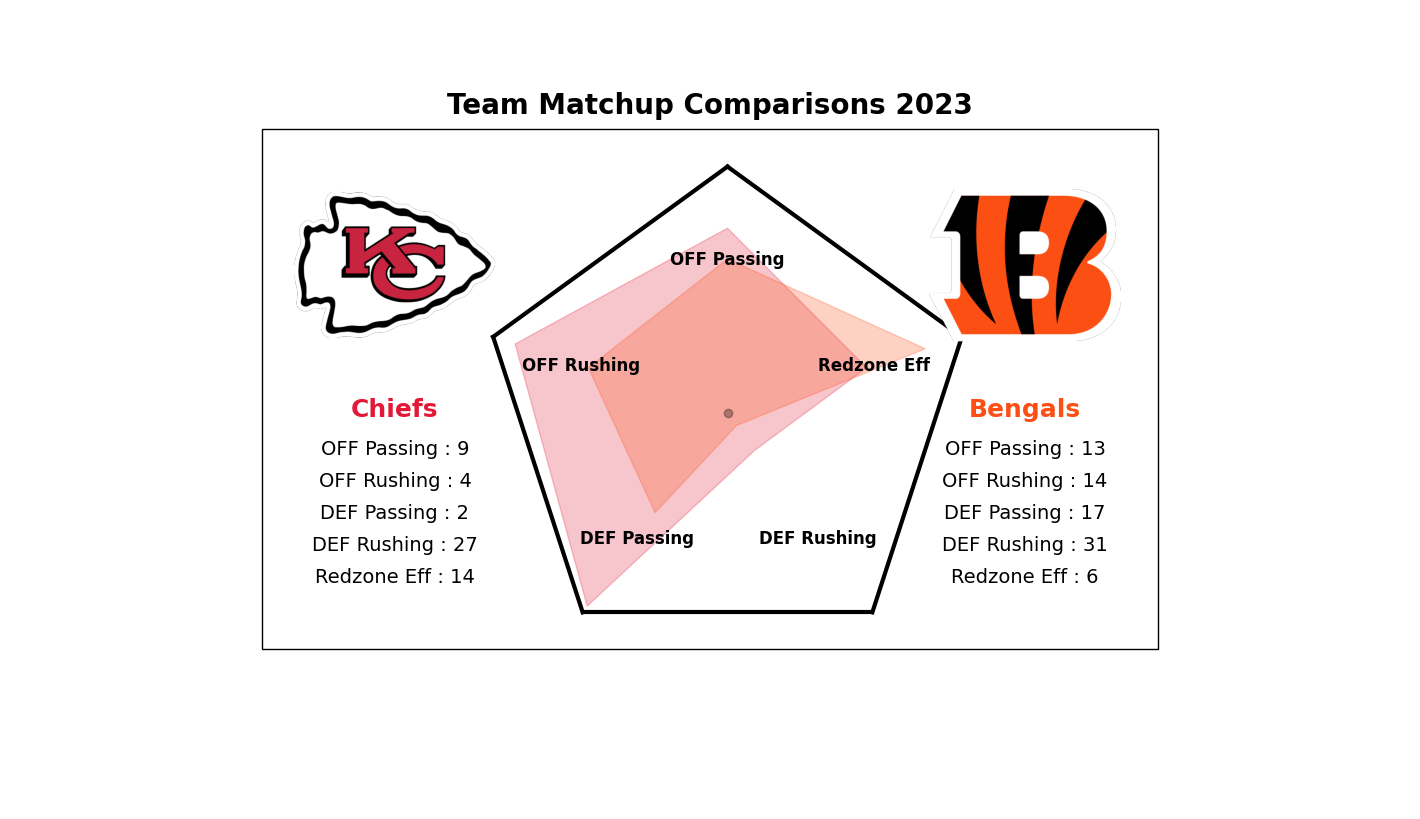

In [22]:
def matchup(inp1, inp2):
  matchup = fin_ranks[fin_ranks["team"].isin([inp1, inp2])]

  # Team
  team = nfl.import_team_desc()

  tm1_info = team[team["team_abbr"] == matchup["team"].values[0]]
  tm2_info = team[team["team_abbr"] == matchup["team"].values[1]]

  team_cols = []
  team_cols.append(tm1_info["team_color"].values[0])
  team_cols.append(tm2_info["team_color"].values[0])


  categories = ["off_passing_rank", "off_rushing_rank", "def_passing_rank", "def_rushing_rank", "redzone_eff_rank"]
  data = matchup.loc[:, categories].values

  first_column = data[:, 0]

  # Append the first column to the end
  data = np.hstack((data, first_column.reshape(-1, 1)))

  category_count = len(list(matchup.columns[1:]))

  labels = ['OFF Passing', 'OFF Rushing', 'DEF Passing', 'DEF Rushing', "Redzone Eff"]

  # Create a list of angles for each category
  start_angle = np.pi / 2

  angles = [start_angle + n / float(category_count) * 2 * np.pi for n in range(category_count)]
  angles += angles[:1]


  # Make the plot
  fig, ax = plt.subplots(figsize=(14,8), subplot_kw=dict(polar=True))


  # Plot the data
  for i in range(len(data)):
    ax.fill(angles, data[i], color=team_cols[i], alpha=0.25)

  # Add labels
  label_radius = 20
  for i in range(5):
    angle = 2 * np.pi / 5 * i + np.pi/2
    ax.text(angle, label_radius, labels[i], ha='center', va='center', fontsize = 12, weight = "heavy")

  x = np.pi / 2
  y = 36

  plt.scatter(0, 0, c='k', alpha = 0.3, marker='o')

  pen_coords = [
      (x, 32),
      (2 * np.pi / 5 + x, 32),
      ( 4*np.pi / 5 + x, 32),
      (6 * np.pi / 5 + x, 32),
      (8 * np.pi / 5 + x, 32)
  ]

  # Add lines connecting the vertices of the hex
  for i in range(len(pen_coords) - 1):
      x1, y1 = pen_coords[i]
      x2, y2 = pen_coords[i + 1]
      ax.plot([x1, x2], [y1, y2], color='k', linewidth=3)

  # Connect the last point to the first point
  x1, y1 = pen_coords[-1]
  x2, y2 = pen_coords[0]
  ax.plot([x1, x2], [y1, y2], color='k', linewidth=3)

  # Set axes
  ax.yaxis.grid(True, linestyle='-', alpha=0.0, color='none')
  ax.xaxis.grid(True, linestyle='-', alpha=0.0, color='none')
  ax.spines['polar'].set_visible(False)
  plt.ylim(0, 40)
  ax.set_yticks(np.arange(0, 40, 2))
  ax.set_yticklabels([])
  ax.set_xticklabels([])

  # Create cartesian axes
  ax2 = plt.axes([0, 0, 1, 1], frameon=False, polar=False)
  ax2.set_xlim(0,100)
  ax2.set_ylim(0,100)
  ax2.set_yticks([])
  ax2.set_xticks([])

  # Box
  rect = patches.Rectangle((18, 20), 64,65, linewidth=1, edgecolor='black', facecolor='none')
  plt.gca().add_patch(rect)

  # Logo
  tm1_logo_url = tm1_info["team_logo_espn"].values[0]
  tm2_logo_url = tm2_info["team_logo_espn"].values[0]

  tm1_logo_img = Image.open(urllib.request.urlopen(tm1_logo_url))
  tm2_logo_img = Image.open(urllib.request.urlopen(tm2_logo_url))

  ax2.imshow(tm1_logo_img, extent=(20, 35, 53, 83), aspect='auto')
  ax2.imshow(tm2_logo_img, extent=(65, 80, 53, 83), aspect='auto')

  ax2.text(27.5, 50, tm1_info["team_nick"].values[0], ha='center', va='center', fontsize = 18, weight = "bold", color=team_cols[0])
  ax2.text(72.5, 50, tm2_info["team_nick"].values[0], ha='center', va='center', fontsize = 18, weight = "bold", color=team_cols[1])

  # Title
  ax2.text(50, 88, "Team Matchup Comparisons 2023", ha='center', va='center', fontsize = 20, weight = "bold")

  # Physical data
  tm1_ranks = matchup.iloc[0]
  height = 45
  i = 0
  for column_name, column_data, in tm1_ranks.items():
    if column_name == "team":
      continue
    ax2.text(27.5, height, f'{labels[i]}' + " : " + f'{abs(33 - column_data)}', ha='center', va='center', fontsize = 14)
    height -= 4
    i += 1

  tm2_ranks = matchup.iloc[1]
  height = 45
  i = 0
  for column_name, column_data, in tm2_ranks.items():
    if column_name == "team":
      continue
    ax2.text(72.5, height, f'{labels[i]}' + " : " + f'{abs(33 - column_data)}', ha='center', va='center', fontsize = 14)
    height -= 4
    i += 1

  # Show the plot
  plt.show()

inp1 = input("First Team Abbreviation: ").upper()
inp2 = input("Second Team Abbreviation: ").upper()

matchup(inp1, inp2)